In [1]:


# ## Cell 1: Imports and Setup
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, cohen_kappa_score
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, Model
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

print(f"TensorFlow Version: {tf.__version__}")
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"GPU(s) available: {len(gpus)}")
else:
    print("No GPU detected.")


2025-10-10 02:20:26.396059: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1760062826.630918      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1760062826.692734      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


TensorFlow Version: 2.18.0
GPU(s) available: 2


In [2]:
# ## Cell 2: Configuration

# Paths to your Kaggle data
TRAIN_CSV = '/kaggle/input/aptos2019-blindness-detection/train.csv'
TRAIN_IMG_DIR = '/kaggle/input/aptos2019-blindness-detection/train_images'

# Model and training hyperparameters
IMG_SIZE = (384, 384)
BATCH_SIZE = 16
SEED = 42
EPOCHS = 25  # Increased from 20 to allow more time for augmentation
NUM_CLASSES = 5

# Set seeds for reproducibility
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [3]:
# ## Cell 3: Load and Prepare Data

# Load the CSV and ensure the diagnosis column is a string for the generator
df = pd.read_csv(TRAIN_CSV)
df['id_code'] = df['id_code'].astype(str) + '.png'

# This line fixes the error by converting the diagnosis labels to strings
df['diagnosis'] = df['diagnosis'].astype(str)

print("Data loaded successfully.")
print(f"Total samples: {len(df)}")

Data loaded successfully.
Total samples: 3662


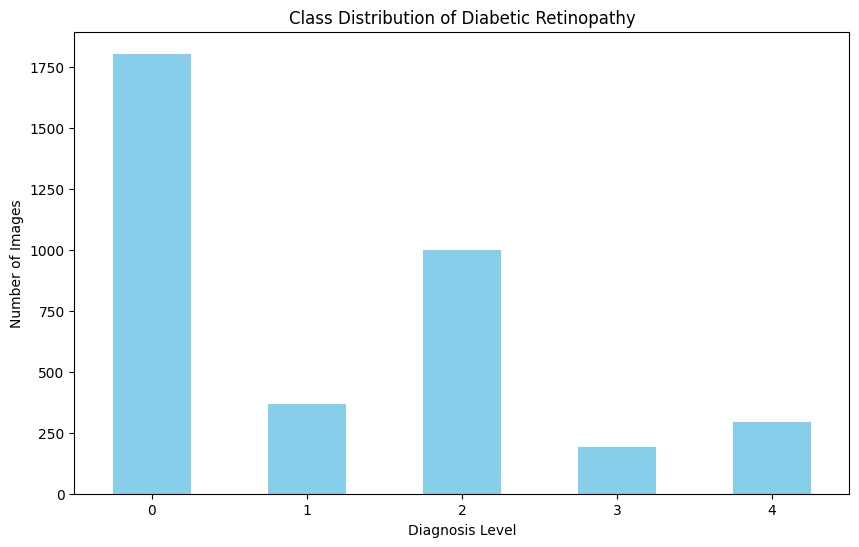

In [4]:
# ## Cell 4: Quick EDA
# Visualize the class distribution
plt.figure(figsize=(10, 6))
df['diagnosis'].value_counts().sort_index().plot(kind='bar', color='skyblue')
plt.title('Class Distribution of Diabetic Retinopathy')
plt.xlabel('Diagnosis Level')
plt.ylabel('Number of Images')
plt.xticks(rotation=0)
plt.show()


In [5]:
# ## Cell 5: Train/Validation Split
# Create a stratified split to maintain class distribution in both sets
train_df, val_df = train_test_split(
    df,
    test_size=0.15,
    random_state=SEED,
    stratify=df['diagnosis']
)

print(f"Training samples: {len(train_df)}")
print(f"Validation samples: {len(val_df)}")


Training samples: 3112
Validation samples: 550


In [6]:
# ## Cell 6: Data Generators (with Augmentations)

# Add basic augmentations to the training generator to combat overfitting
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    horizontal_flip=True,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1
)

# The validation generator should NOT have augmentations
val_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=TRAIN_IMG_DIR,
    x_col='id_code',
    y_col='diagnosis',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='sparse',
    shuffle=True,
    seed=SEED
)

val_gen = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    directory=TRAIN_IMG_DIR,
    x_col='id_code',
    y_col='diagnosis',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='sparse',
    shuffle=False
)

Found 3112 validated image filenames belonging to 5 classes.
Found 550 validated image filenames belonging to 5 classes.


In [7]:
# ## Cell 7: Calculate Class Weights
# Correctly compute class weights on the integer labels to handle imbalance
classes = np.unique(train_df['diagnosis'])
class_weights = compute_class_weight(
    'balanced',
    classes=classes,
    y=train_df['diagnosis'].values
)
class_weight_dict = {c: w for c, w in zip(classes, class_weights)}

print("Class weights calculated:")
print(class_weight_dict)

Class weights calculated:
{'0': 0.4057366362451108, '1': 1.9821656050955414, '2': 0.7330977620730271, '3': 3.795121951219512, '4': 2.4796812749003982}


In [8]:
# ## Cell 8: Build the Model
def build_simple_model(input_shape=IMG_SIZE + (3,), n_classes=NUM_CLASSES):
    """Builds a simple, robust EfficientNetB0 model for single-phase training."""
    # Base model
    base = EfficientNetB0(
        include_top=False,
        weights='imagenet',
        input_shape=input_shape
    )
    base.trainable = True # Train the whole model

    # Model architecture
    inputs = layers.Input(shape=input_shape)
    x = base(inputs, training=True)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(n_classes, activation='softmax')(x)
    model = Model(inputs, outputs)

    # Compile the model with the correct loss function
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
        loss='sparse_categorical_crossentropy', # The correct loss for 'sparse' mode
        metrics=['accuracy']
    )
    return model

model = build_simple_model()
model.summary()


I0000 00:00:1760062851.268605      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1760062851.269291      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 384, 384, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 12, 12, 1280)   │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 5)              │         6,405 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,055,976 (15.47 MB)

 Trainable params: 4,013,953 (15.31 MB)

 Non-trainable params: 42,023 (164.16 KB)

In [9]:
# ## Cell 9: Define Callbacks (with Gentler LR Reduction)
checkpoint = ModelCheckpoint(
    'best_model.h5',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=5, # Stop if no improvement for 5 epochs
    restore_best_weights=True,
    mode='max',
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,  # Changed to 0.5 for a gentler reduction
    patience=2,
    verbose=1,
    min_lr=1e-7
)



In [10]:
# ## Cell 10: Train the Model
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS,
    class_weight=class_weight_dict,
    callbacks=[checkpoint, early_stopping, reduce_lr],
    verbose=1
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25


I0000 00:00:1760062914.398190      60 service.cc:148] XLA service 0x7bc928005400 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1760062914.399336      60 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1760062914.399359      60 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1760062919.501446      60 cuda_dnn.cc:529] Loaded cuDNN version 90300
E0000 00:00:1760062924.263435      60 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1760062924.463519      60 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1760062932.145900      60 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. Th

 76/195 ━━━━━━━━━━━━━━━━━━━━ 4:31 2s/step - accuracy: 0.5438 - loss: 1.2026

E0000 00:00:1760063133.704554      63 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1760063133.874186      63 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1760063139.458046      63 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1760063139.595584      63 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1760063140.086619      63 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:0

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6320 - loss: 0.9980

E0000 00:00:1760063509.361795      63 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1760063509.523827      63 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.



Epoch 1: val_accuracy improved from -inf to 0.49273, saving model to best_model.h5
195/195 ━━━━━━━━━━━━━━━━━━━━ 655s 3s/step - accuracy: 0.6325 - loss: 0.9969 - val_accuracy: 0.4927 - val_loss: 1.3933 - learning_rate: 1.0000e-04
Epoch 2/25
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7792 - loss: 0.5856
Epoch 2: val_accuracy improved from 0.49273 to 0.62727, saving model to best_model.h5
195/195 ━━━━━━━━━━━━━━━━━━━━ 422s 2s/step - accuracy: 0.7792 - loss: 0.5856 - val_accuracy: 0.6273 - val_loss: 1.0578 - learning_rate: 1.0000e-04
Epoch 3/25
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8257 - loss: 0.4742
Epoch 3: val_accuracy improved from 0.62727 to 0.70182, saving model to best_model.h5
195/195 ━━━━━━━━━━━━━━━━━━━━ 421s 2s/step - accuracy: 0.8257 - loss: 0.4742 - val_accuracy: 0.7018 - val_loss: 0.8117 - learning_rate: 1.0000e-04
Epoch 4/25
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8139 - loss: 0.4745
Epoch 4: val_accuracy did not improve from 0.70182


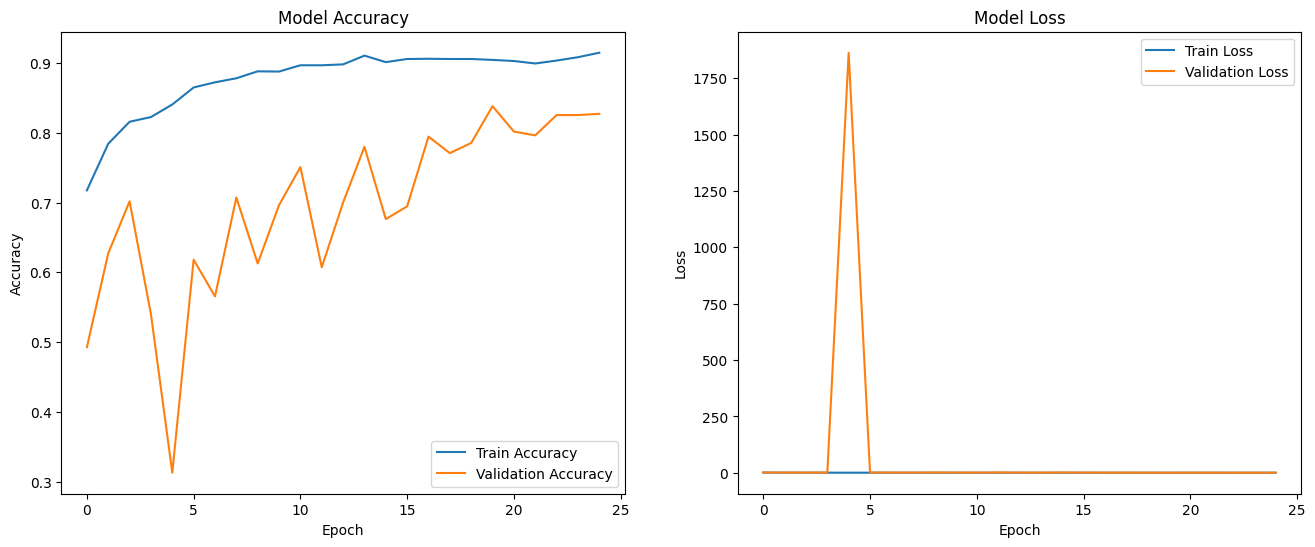

In [11]:
# ## Cell 11: Plot Training History
def plot_history(history):
    """Plots accuracy and loss curves for training and validation."""
    fig, ax = plt.subplots(1, 2, figsize=(16, 6))

    # Plot accuracy
    ax[0].plot(history.history['accuracy'], label='Train Accuracy')
    ax[0].plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax[0].set_title('Model Accuracy')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Accuracy')
    ax[0].legend()

    # Plot loss
    ax[1].plot(history.history['loss'], label='Train Loss')
    ax[1].plot(history.history['val_loss'], label='Validation Loss')
    ax[1].set_title('Model Loss')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Loss')
    ax[1].legend()

    plt.show()

plot_history(history)



35/35 ━━━━━━━━━━━━━━━━━━━━ 64s 2s/step

📈 Validation Quadratic Weighted Kappa (QWK): 0.8682

📊 Classification Report:

              precision    recall  f1-score   support

           0       0.96      0.98      0.97       271
           1       0.65      0.54      0.59        56
           2       0.74      0.91      0.81       150
           3       0.75      0.31      0.44        29
           4       0.62      0.45      0.53        44

    accuracy                           0.84       550
   macro avg       0.75      0.64      0.67       550
weighted avg       0.83      0.84      0.83       550



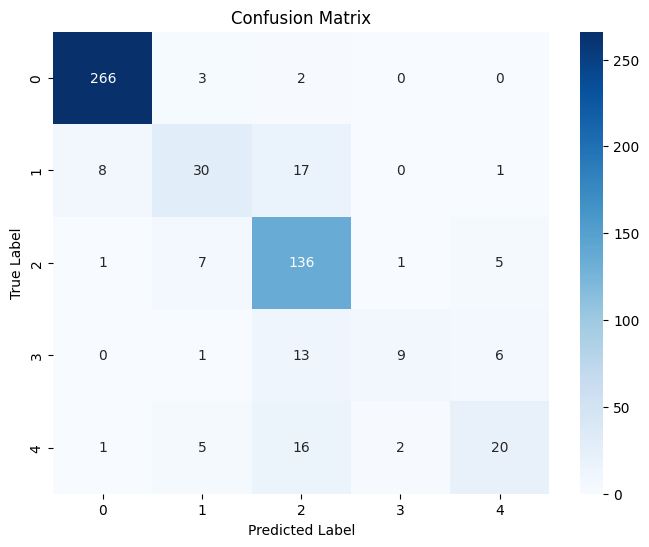

In [12]:
# ## Cell 12: Evaluate the Model
# Load the best performing model
model.load_weights('best_model.h5')

# Make predictions on the validation set
preds = model.predict(val_gen)
pred_classes = np.argmax(preds, axis=1)

# Get true labels directly from the generator for robust evaluation
true_classes = val_gen.classes

# Calculate Quadratic Weighted Kappa
qwk = cohen_kappa_score(true_classes, pred_classes, weights='quadratic')
print(f"\n📈 Validation Quadratic Weighted Kappa (QWK): {qwk:.4f}\n")

# Print Classification Report
print("📊 Classification Report:\n")
print(classification_report(true_classes, pred_classes, target_names=[str(i) for i in classes]))

# Display Confusion Matrix
cm = confusion_matrix(true_classes, pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=classes, yticklabels=classes)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()